In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
dataset = 'fashion_mnist'

if dataset == 'fashion_mnist':
  from keras.datasets import fashion_mnist
  (xfull, yfull), (xtest, ytest) = fashion_mnist.load_data()
  class_labels = {0: 'T-Shirt',
                1: 'Trouser',
                2: 'Pullover',
                3: 'Dress',
                4: 'Coat',
                5: 'Sandal',
                6: 'Shirt',
                7: 'Sneaker',
                8: 'Bag',
                9: 'Ankle Boot'}

elif dataset == 'mnist':
  from keras.datasets import mnist
  (xfull, yfull), (xtest, ytest) = mnist.load_data()
  class_labels = {0: '0',
                1: '1',
                2: '2',
                3: '3',
                4: '4',
                5: '5',
                6: '6',
                7: '7',
                8: '8',
                9: '9'}

else:
  raise Exception('Incorrect Dataset Name')

xtrain, xval, ytrain, yval = train_test_split(xfull, yfull, test_size = 0.1)

print('X Train Shape: ', xtrain.shape)
print('Y Train Shape: ', ytrain.shape)
print('X Validation Shape: ', xval.shape)
print('Y Validation Shape: ', yval.shape)
print('X Test Shape: ', xtest.shape)
print('Y Test Shape: ', ytest.shape)
print('Number of classes: ', len(set(ytrain)))

X Train Shape:  (54000, 28, 28)
Y Train Shape:  (54000,)
X Validation Shape:  (6000, 28, 28)
Y Validation Shape:  (6000,)
X Test Shape:  (10000, 28, 28)
Y Test Shape:  (10000,)
Number of classes:  10


## TRY USING STANDARD SCALAR HERE

In [3]:
xtrain_inp = xtrain.reshape((xtrain.shape[0], -1))/255.0
xval_inp = xval.reshape((xval.shape[0], -1))/255.0
xtest_inp = xtest.reshape((xtest.shape[0], -1))/255.0
ytrain_inp = np.array(pd.get_dummies(ytrain))
yval_inp = np.array(pd.get_dummies(yval))
ytest_inp = np.array(pd.get_dummies(ytest))

# Question 1

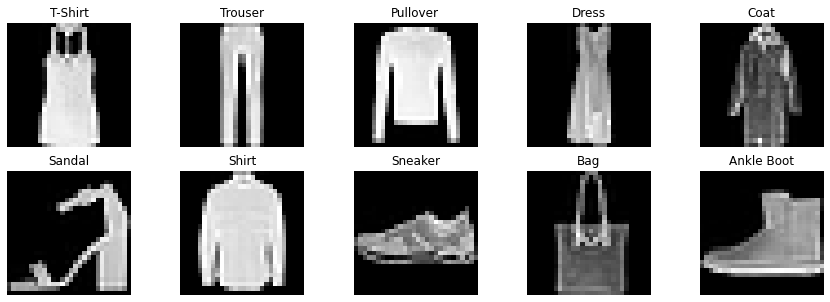

In [4]:
i = 5 # can change to view different images
idxs = {k:np.where(ytrain==k)[0][i] for k in set(ytrain)}
fig, axs = plt.subplots(2, 5, figsize=(15,5))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(xtrain[idxs[i], :, :], cmap='gray')
  ax.set_title(class_labels[i])
  ax.axis('off')

## Helper Functions

In [5]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

def sigmoid_der(x):
  return sigmoid(x) * (1-sigmoid(x))

def relu(x):
  return np.maximum(0, x)

def relu_der(x):
  x[x>0] = 1
  x[x<=0] = 0
  return x

def tanh(x):
  return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def tanh_der(x):
  return 1 - tanh(x) ** 2

def identity(x):
  return x

def identity_der(x):
  return np.ones(x.shape)

def get_activation(act):
  if act == 'sigmoid':
    act = sigmoid
    act_der = sigmoid_der
  elif act == 'ReLU':
    act = relu
    act_der = relu_der
  elif act== 'tanh':
    act = tanh
    act_der = tanh_der
  elif act == 'identity':
    act = identity
    act_der = identity_der
  else:
    raise Exception('Incorrect Activation Function')
  return act, act_der

def softmax(x):
  xsum = np.sum(np.exp(x), axis=1, keepdims=True)
  res = np.exp(x)/xsum
  return res

def cross_entropy(y, yhat):
  """ 
  Returns Average Cross Entropy Loss over the input data points
  - Epsilon is used so that log is not taken over 0
  """
  epsilon = 1e-30
  losses = -np.sum(y * np.log(yhat + epsilon), axis=1)
  return np.mean(losses)

def cross_entropy_der(y, yhat):
  return -(y - yhat)

def mean_squared_error(y, yhat):
  return np.mean(np.sum((y-yhat)**2, axis=1))

def mean_squared_error_der(y, yhat):
  pass

def accuracy(y, yhat):
  return np.sum(np.argmax(y, axis=1) ==  np.argmax(yhat, axis=1))

# Question 2

In [6]:
def init_params(n_inp, n_hidden, n_out, seed=None):
  if seed is not None:
    np.random.seed(seed)
  NN = [n_inp] + n_hidden + [n_out]
  params = {}
  for i in range(1, len(NN)):
    params['W' + str(i)] = np.random.randn(NN[i-1], NN[i]) * 0.01
    params['B' + str(i)] = np.zeros((1, NN[i]))
  return params

def forward(inp, params, activation):
  L = len(params) // 2
  cache = {'H0':inp}
  for i in range(1, L+1):
    cache['A' + str(i)] = cache['H' + str(i-1)] @ params['W' + str(i)] + params['B' + str(i)]
    cache['H' + str(i)] = sigmoid(cache['A' + str(i)])
  cache['A' + str(L)] = cache['H' + str(L-1)] @ params['W' + str(L)] + params['B' + str(L)]
  cache['H' + str(L)] = softmax(cache['A' + str(L)])
  yhat = cache['H' + str(L)]
  return yhat, cache

# Question 3

In [7]:
def backward(y, params, yhat, cache, act_der, loss_func):
  L = len(params) // 2
  m = y.shape[0]
  
  if loss_func == 'cross_entropy':
    loss_func_ = cross_entropy
    loss_func_der = cross_entropy_der
  elif loss_func == 'mean_squared_error':
    loss_func_ = mean_squared_error
    loss_func_der = mean_squared_error_der
  else:
    raise Exception('Incorrect Loss Function')
  loss = loss_func_(y, yhat)
  acc = accuracy(y, yhat)
  del_params = {} 
  del_ak = loss_func_der(y, yhat)
  for k in range(L, 0, -1):
    del_params['W' + str(k)] = (cache['H' + str(k-1)].T @ del_ak) / m
    del_params['B' + str(k)] = np.sum(del_ak, axis=0, keepdims=True) / m
    if k != 1:
      del_ak = (del_ak @ params['W' + str(k)].T) * act_der(cache['A' + str(k-1)])
  return del_params, loss, acc


# how exactly to do derivative rectification in adam and nadam? does the "i" in slides refer to the number of epochs or the epochs and number of batches done (i.e. number of updates)?

In [8]:
def train(xtrain, ytrain, xval, yval, n_hidden, config, seed=None):

  activation = config['activation']
  loss_func = config['loss_func']
  optim = config['optim']
  MOMENTUM = config['MOMENTUM']
  BETA = config['BETA']
  BETA1 = config['BETA1']
  BETA2 = config['BETA2']
  EPSILON = config['EPSILON']
  LR = config['LR']
  BATCH_SIZE = config['BATCH_SIZE']
  EPOCHS = config['EPOCHS']

  if seed is not None:
    np.random.seed(0)
  params = init_params(n_inp = xtrain.shape[1], n_hidden = n_hidden, n_out = ytrain.shape[1], seed = seed)

  # if optim=='adam':
  #   for k in params:
  #     params[k] = params[k].astype(np.float128)

  act, act_der = get_activation(activation)

  U = {k:0 for k in params.keys()}
  V = {k:0 for k in params.keys()}

  for i in range(1, EPOCHS+1):

    # if optim == 'SGD':
    #   batches = np.arange(xtrain.shape[0])
    #   np.random.shuffle(batches)
    #   batches = [[k] for k in batches]
    # else:
    #   temp = np.arange(xtrain.shape[0])
    #   np.random.shuffle(temp)
    #   n_batches = xtrain.shape[0] // BATCH_SIZE
    #   batches = temp[:n_batches*BATCH_SIZE].reshape(-1, BATCH_SIZE).tolist()
    #   if  xtrain.shape[0] % BATCH_SIZE != 0:
    #     batches = batches + [temp[n_batches*BATCH_SIZE:].tolist()]

    temp = np.arange(xtrain.shape[0])
    np.random.shuffle(temp)
    n_batches = xtrain.shape[0] // BATCH_SIZE
    batches = temp[:n_batches*BATCH_SIZE].reshape(-1, BATCH_SIZE).tolist()
    if  xtrain.shape[0] % BATCH_SIZE != 0:
      batches = batches + [temp[n_batches*BATCH_SIZE:].tolist()]

    loss = []
    acc = []

    for j, batch in enumerate(batches):
      if optim == 'sgd':
        yhat, cache = forward(xtrain[batch, :], params, act)
        del_params, _loss, _acc = backward(ytrain[batch], params, yhat, cache, act_der, loss_func) 
        for k in params.keys():
          params[k] = params[k] - LR * del_params[k]

      elif optim == 'momentum':
        yhat, cache = forward(xtrain[batch, :], params, act)
        del_params, _loss, _acc = backward(ytrain[batch], params, yhat, cache, act_der, loss_func) 
        for k in params.keys():
          U[k] = MOMENTUM * U[k] + del_params[k]
          params[k] = params[k] - LR * U[k]

      elif optim == 'nag':
        # params Look ahead
        params_LA = {k: (params[k] - MOMENTUM * U[k]) for k in params.keys()}
        yhat, cache = forward(xtrain[batch, :], params_LA, act)
        del_params, _loss, _acc = backward(ytrain[batch], params_LA, yhat, cache, act_der, loss_func) 
        for k in params.keys():
          U[k] = MOMENTUM * U[k] + del_params[k]
          params[k] = params[k] - LR * U[k]

      elif optim == 'rmsprop':
        yhat, cache = forward(xtrain[batch, :], params, act)
        del_params, _loss, _acc = backward(ytrain[batch], params, yhat, cache, act_der, loss_func) 
        for k in params.keys():
          V[k] = BETA * V[k] + (1-BETA) * (del_params[k] ** 2)
          params[k] = params[k] - (LR / np.sqrt(V[k] + EPSILON)) * del_params[k]

      elif optim=='adam':
        yhat, cache = forward(xtrain[batch, :], params, act)
        del_params, _loss, _acc = backward(ytrain[batch], params, yhat, cache, act_der, loss_func) 
        n_updates = (i-1) * len(batches) + (j+1)
        for k in params.keys():
          U[k] = BETA1 * U[k] + (1-BETA1) * del_params[k]
          Uk_hat = U[k] / (1-BETA1**n_updates)
          V[k] = BETA2 * V[k] + (1-BETA2) * del_params[k]**2
          Vk_hat = V[k] / (1-BETA2**n_updates)
          params[k] = params[k] - (LR / (np.sqrt(Vk_hat) + EPSILON)) * Uk_hat

      elif optim=='nadam':
        yhat, cache = forward(xtrain[batch, :], params, act)
        del_params, _loss, _acc = backward(ytrain[batch], params, yhat, cache, act_der, loss_func) 
        n_updates = (i-1) * len(batches) + (j+1)
        for k in params.keys():
          U[k] = BETA1 * U[k] + (1-BETA1) * del_params[k]
          Uk_hat = U[k] / (1-BETA1**n_updates)
          V[k] = BETA2 * V[k] + (1-BETA2) * del_params[k]**2
          Vk_hat = V[k] / (1-BETA2**n_updates)
          params[k] = params[k] - (LR / (np.sqrt(Vk_hat) + EPSILON)) * (BETA1 * Uk_hat + (1 - BETA1) * del_params[k] / (1 - BETA1**n_updates))
          
      else:
        raise Exception('Incorrect Optimizer')
      
      loss.append(_loss)
      acc.append(_acc)

    
    if (i % 10 == 0):
      if xval is None:
        print(f'Epoch {i}:: Training: Loss = {np.mean(loss):.4f} Accuracy = {np.sum(acc)/ytrain.shape[0]:.4f}')
      elif xval is not None and yval is not None:
        yhat, cache = forward(xval, params, act)
        _, loss_val, acc_val = backward(yval, params, yhat, cache, act_der, loss_func)
        print(f'Epoch {i}:: Training: Loss = {np.mean(loss):.4f} Accuracy = {np.sum(acc)/ytrain.shape[0]:.4f}  Validation: Loss = {loss_val:.4f} Accuracy = {acc_val/yval.shape[0]:.4f}')
      
  # yhat, cache = forward(xtrain, params, act)
  # _, loss, acc = backward(ytrain, params, yhat, cache, act_der, loss_func) 
  # print(f'Final:: Training: Loss = {loss:.4f} Accuracy = {acc/ytrain.shape[0]:.4f}') 
  return params

## Testing

In [9]:
config = {'activation': 'sigmoid',
          'loss_func': 'cross_entropy',
          'optim': 'nadam',
          'MOMENTUM': 0.9,
          'BETA': 0.9,
          'BETA1': 0.9,
          'BETA2': 0.999, 
          'EPSILON': 0.000001,
          'LR': 1e-2,
          'BATCH_SIZE': 64, 
          'EPOCHS': 10}

train(xtrain=xtrain_inp, ytrain=ytrain_inp, xval=xval_inp, yval=yval_inp, n_hidden=[64, 32], config=config, seed=0)

Epoch 10:: Training: Loss = 0.3535 Accuracy = 0.8700  Validation: Loss = 0.3659 Accuracy = 0.8713


{'W1': array([[-7.29966073e-01,  3.90403156e-03, -3.71375696e-02, ...,
          1.30202640e-01,  5.41030308e-01, -1.86301194e-01],
        [-6.62590240e-01, -1.16611249e-03, -7.38668900e-02, ...,
         -2.75126723e-01,  2.74479519e-01,  4.80721455e-01],
        [-1.54143829e+00,  3.05739600e-03,  8.92207790e-03, ...,
          2.11736708e+00,  1.05585142e+00, -3.35680539e-02],
        ...,
        [-8.67791512e-01,  3.36615295e-01,  5.88461623e-02, ...,
          1.82809338e+00,  3.00485096e-01,  6.79269797e-01],
        [-9.05914593e-02,  1.83463079e-02,  4.01190028e-02, ...,
          8.97355432e-01,  4.71242413e-01,  4.21833940e-01],
        [ 1.35002869e-01,  8.80285237e-03, -6.95420005e-03, ...,
          8.03119230e-01,  4.80965444e-01,  1.57395330e-01]]),
 'B1': array([[ 0.17312965, -0.20862836, -0.58581188,  0.69505812, -0.18180674,
          0.64657678,  3.02468771, -0.13784907, -0.23345324, -1.15865962,
         -2.56182034,  0.08973431, -2.13003444, -0.79944166,  0.93160